In [2]:
import uproot
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import math
import csv
import math
import seaborn as sns
import sympy as smp
import sympy.stats
from scipy import stats,signal,ndimage,special,fft
from scipy.optimize import curve_fit
from scipy.integrate import quad
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

In [3]:
tracks = uproot.open("/nashome/z/zaemoore/2x2_CAF/purity_efficiency/2p2h_purity_output_1.1.root")
tracks["RecoTree"].show()
tracks["RecoTree"].keys()

branches = tracks["RecoTree"].arrays()[0]
file_index = branches['file_index']
print(np.unique(file_index))

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
reco_energy          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_x             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_y             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_z             | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_p_mag           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_length          | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_rot       | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_incl      | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_x         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
reco_angle_y         | std::

Cuts

In [4]:
def cuts(pdg_truth, p_truth, pdg_reco, p_reco):
    reco_passes = 0
    truth_reco_passes = 0

    nprotons_truth = np.count_nonzero(pdg_truth == 2212)
    nmuons_truth = np.count_nonzero(pdg_truth == 13)
    npions_truth = np.count_nonzero(pdg_truth == 111) + np.count_nonzero(pdg_truth == 211) + np.count_nonzero(pdg_truth == -211) 

    nprotons_reco = np.count_nonzero(pdg_reco == 2212)
    nmuons_reco = np.count_nonzero(pdg_reco == 13)
    npions_reco = np.count_nonzero(pdg_reco == 111) + np.count_nonzero(pdg_reco == 211) + np.count_nonzero(pdg_reco == -211) 


    if nprotons_reco == 2 and nmuons_reco == 1 and npions_reco == 0:
        reco_passes = 1
        if nprotons_truth == 2 and nmuons_truth == 1 and npions_truth == 0:
            truth_reco_passes = 1

    return (reco_passes, truth_reco_passes)


Calculate Purity <br>
Purity = Number of True CC1mu2p0pi Events that pass all cuts/Number of events that pass all cuts

In [5]:
#Arrays to save information
num_true_events = []
num_total_events = []

#For plots (save from reco information)
leading_p_p = []
recoil_p_p = []
theta_pp = []


#Loop through each file index
for file_idx in np.unique(file_index):
    true_energy = branches['true_energy'][file_index == file_idx]
    true_p_x = branches['true_p_x'][file_index == file_idx]
    true_p_y = branches['true_p_y'][file_index == file_idx]
    true_p_z = branches['true_p_z'][file_index == file_idx]
    true_p_mag = branches['true_p_mag'][file_index == file_idx]
    true_length = branches['true_length'][file_index == file_idx]
    true_angle = branches['true_angle'][file_index == file_idx]
    true_angle_rot = branches['true_angle_rot'][file_index == file_idx]
    true_angle_incl = branches['true_angle_incl'][file_index == file_idx]
    true_angle_x = branches['true_angle_x'][file_index == file_idx]
    true_angle_y = branches['true_angle_y'][file_index == file_idx]
    true_angle_z = branches['true_angle_z'][file_index == file_idx]
    true_track_start_x = branches['true_track_start_x'][file_index == file_idx]
    true_track_start_y = branches['true_track_start_y'][file_index == file_idx]
    true_track_start_z = branches['true_track_start_z'][file_index == file_idx]
    true_track_end_x = branches['true_track_end_x'][file_index == file_idx]
    true_track_end_y = branches['true_track_end_y'][file_index == file_idx]
    true_track_end_z = branches['true_track_end_z'][file_index == file_idx]
    true_pdg = branches['true_pdg'][file_index == file_idx]
    true_nproton = branches['true_nproton'][file_index == file_idx]

    reco_energy = branches['reco_energy'][file_index == file_idx]
    reco_p_x = branches['reco_p_x'][file_index == file_idx]
    reco_p_y = branches['reco_p_y'][file_index == file_idx]
    reco_p_z = branches['reco_p_z'][file_index == file_idx]
    reco_p_mag = branches['reco_p_mag'][file_index == file_idx]
    reco_length = branches['reco_length'][file_index == file_idx]
    reco_angle = branches['reco_angle'][file_index == file_idx]
    reco_angle_rot = branches['reco_angle_rot'][file_index == file_idx]
    reco_angle_incl = branches['reco_angle_incl'][file_index == file_idx]
    reco_angle_x = branches['reco_angle_x'][file_index == file_idx]
    reco_angle_y = branches['reco_angle_y'][file_index == file_idx]
    reco_angly_z = branches['reco_angle_z'][file_index == file_idx]
    reco_track_start_x = branches['reco_track_start_x'][file_index == file_idx]
    reco_track_start_y = branches['reco_track_start_y'][file_index == file_idx]
    reco_track_start_z = branches['reco_track_start_z'][file_index == file_idx]
    reco_track_end_x = branches['reco_track_end_x'][file_index == file_idx]
    reco_track_end_y = branches['reco_track_end_y'][file_index == file_idx]
    reco_track_end_z = branches['reco_track_end_z'][file_index == file_idx]
    reco_pdg = branches['reco_pdg'][file_index == file_idx]
    reco_ixn_index = branches['reco_ixn_index'][file_index == file_idx]
    spill_index = branches['spill_index'][file_index == file_idx]
    event = branches['event'][file_index == file_idx]
    subrun = branches['subrun'][file_index == file_idx]
    caf_file_name = branches['caf_file_name'][file_index == file_idx]

    #Loop through each event in the file
    for ev in np.unique(event):

        reco_passes, truth_reco_passes = cuts(true_pdg[event == ev], true_p_mag[event == ev], reco_pdg[event == ev], reco_p_mag[event == ev])
        num_total_events.append(reco_passes)
        num_true_events.append(truth_reco_passes)
        
        #Save proton momentum information for plots
        proton_p_reco = reco_p_mag[event == ev][reco_pdg[event == ev] == 2212]
        leading_p_p.append(max(proton_p_reco))
        recoil_p_p.append(min(proton_p_reco))

        #Save angle between protons for plots FOR LATER


purity = sum(num_true_events)/sum(num_total_events)
print("Purity measurement: ", purity)

Purity measurement:  0.08072487644151564


Purity plots

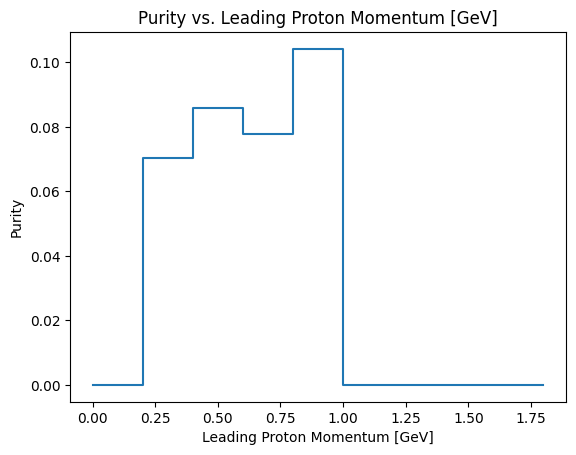

     passes cuts  signal passes cuts  leading proton p  recoil proton p  \
0              1                   0          0.459065         0.114610   
1              1                   0          0.593397         0.457576   
2              1                   0          0.682856         0.222758   
3              1                   0          0.682304         0.361678   
4              1                   0          0.858352         0.782534   
..           ...                 ...               ...              ...   
615            1                   0          0.495677         0.338615   
616            1                   0          0.455176         0.407003   
617            1                   0          0.356980         0.339610   
618            1                   0          0.262027         0.194671   
619            1                   0          0.541699         0.290540   

    bin lpp bin rpp  
0         2       0  
1         2       2  
2         3       1  
3         3

In [ ]:
data = {'passes cuts': num_total_events, 'signal passes cuts': num_true_events, 'leading proton p': leading_p_p, 'recoil proton p': recoil_p_p}
df = pd.DataFrame(data=data)

purity_vals_lpp = []
purity_vals_rpp = []


nbins_lpp = 10
hist_lpp, bin_edges_lpp = np.histogram(leading_p_p, bins=nbins_lpp, range=(0,2)) #Create bins based on leading proton momentum
labels_lpp = np.arange(0, nbins_lpp) #Label each bin numerically for leading proton momentum

df['bin lpp'] = pd.cut(df['leading proton p'], bins=bin_edges_lpp, labels=labels_lpp) #Create a column in df defining the number bin each event is in based on leading proton momentum

#repeat for recoil proton momentum
nbins_rpp = 10
hist_rpp, bin_edges_rpp = np.histogram(recoil_p_p, bins=nbins_rpp, range=(0,2)) #Create bins based on recoil proton momentum
labels_rpp = np.arange(0, nbins_rpp) #Label each bin numerically for recoil proton momentum

df['bin rpp'] = pd.cut(df['recoil proton p'], bins=bin_edges_rpp, labels=labels_rpp) #Create a column in df defining the number bin each event is in based on recoil proton momentum


#Loop through each bin and calculate purity, then save to purity array for leading proton momentum
for i in labels_lpp:
    df_bin = df[(df['bin lpp'] == i)]

    passes_cut_bin = np.array(df_bin['passes cuts'])
    signal_passes_cut_bin = np.array(df_bin['signal passes cuts'])

    if sum(passes_cut_bin) == 0:
        purity_vals_lpp.append(0)
    else:
        purity_vals_lpp.append(sum(signal_passes_cut_bin)/sum(passes_cut_bin))

#Loop through each bin and calculate purity, then save to purity array for recoil proton momentum


#Plot use step plot
plt.step(np.delete(bin_edges_lpp, nbins_lpp), purity_vals_lpp, where='post', label='label')
#Delete the last bin value because we are plotting each step from the leftmost bin edge
plt.xlabel('Leading Proton Momentum [GeV]')
plt.ylabel('Purity')
plt.title('Purity vs. Leading Proton Momentum [GeV]')
plt.show()

print(df)